# Custom priors

Let's look at something a bit more complicated now, using custom priors to define the model instead of the pb1 and pb2 models provided by Maelstrom.

In [1]:
from maelstrom.orbit import Orbit
import numpy as np
import exoplanet as xo
from maelstrom import Maelstrom
import matplotlib.pyplot as plt

We'll go back to our favourite star..

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


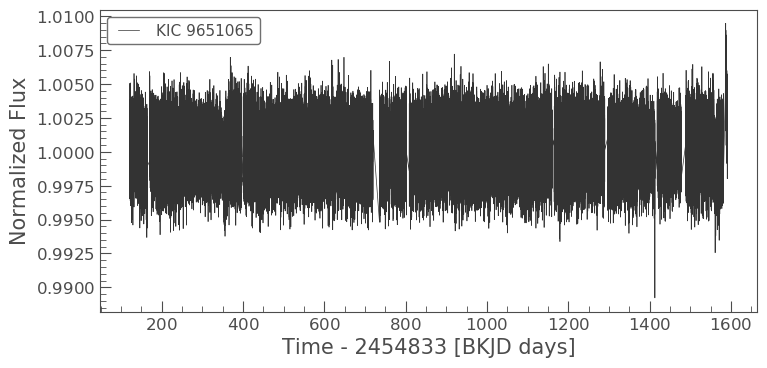

In [2]:
import lightkurve as lk

lc = lk.search_lightcurvefile('KIC 9651065', mission='Kepler').download_all().stitch().remove_nans()
lc.plot()

As usual, pass the time and flux data into Maelstrom

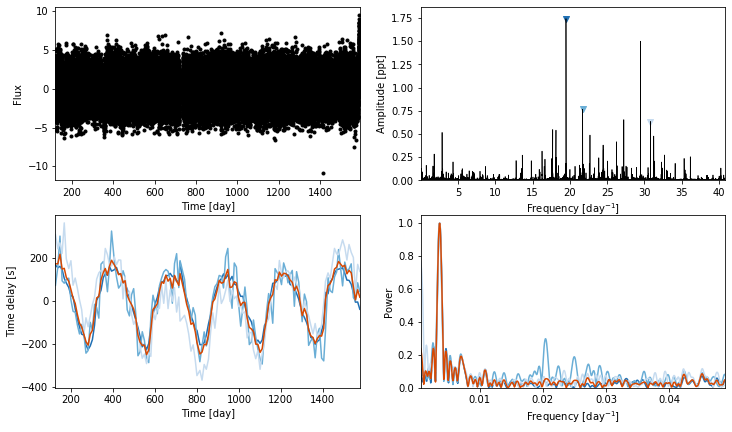

In [3]:
ms = Maelstrom(lc.time, lc.flux, max_peaks=3, fmax=48)
ms.first_look();

In [5]:
freq = ms.freq
time, flux = ms.time, ms.flux

Here is where we define our custom model. PyMC3 has a steep learning curve, so I recommend reading the documentation. In a nutshell, we defined a `PyMC3.Model()` as a context manager and bind our priors to the model. You can choose a wide range of distributions for your priors (or even write your own), such as `pm.Uniform`, `pm.Normal`, `pm.Binomial`, and so on. [Check them all out here](https://docs.pymc.io/api/distributions.html)

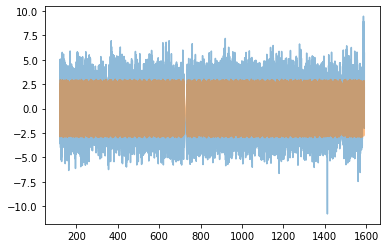

In [7]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # Our orbital period prior
    period = pm.Normal("period", mu=300, sd=50)
    # The phase of conjunction
    phi = xo.distributions.Angle("phi")
    # Our standard deviation
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    # We want positive lighttimes only, sample in log-space
    logasini = pm.Normal('logasini', mu=np.log(200), sd=100, testval=np.log(200))
    asini = pm.Deterministic("asini", pm.math.exp(logasini))
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", pm.math.exp(lognu))
    
    # Here, we generate an Orbit instance and pass in our priors. 
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu)
    
    # Orbit makes available a method which will calculate the theoretical light curve given the orbital parameters, times, and fluxes, following
    # equation 10 of the paper. 
    lc = orbit.get_lightcurve_model(time, flux) + mean
    
    # We pass this into our likelihood
    pm.Normal('obs', mu=lc, sd=tt.exp(logs_lc), observed=flux)

# This is what our light curve looks like before any optimisation
with model:
    plt.plot(time, flux, alpha=0.5, label='Data')
    plt.plot(time, xo.eval_in_model(lc), alpha=0.5, label='Model')

Now let's optimise the model. You can see that I do it in steps

In [8]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)

[period, phi_angle__, logs_lc, logasini, omega_angle__, eccen_interval__, mean, lognu]


optimizing logp for variables: [mean]
4it [00:01,  3.00it/s, logp=-1.171448e+05]
message: Optimization terminated successfully.
logp: -117144.9588750656 -> -117144.76447374036
optimizing logp for variables: [logs_lc]
8it [00:00, 30.51it/s, logp=-1.109120e+05]
message: Optimization terminated successfully.
logp: -117144.76447374036 -> -110912.00530457776
optimizing logp for variables: [omega, eccen]
37it [00:01, 24.89it/s, logp=-1.076884e+05]
message: Optimization terminated successfully.
logp: -110912.00530457776 -> -107688.4449469986
optimizing logp for variables: [phi]
19it [00:00, 26.69it/s, logp=-1.076658e+05]
message: Optimization terminated successfully.
logp: -107688.4449469986 -> -107665.81519841329
optimizing logp for variables: [lognu, mean, eccen, omega, logasini, logs_lc, phi, period]
147it [00:05, 26.84it/s, logp=-1.064790e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -107665.81519841329 -> -106479.01236356102
optimizing logp for variabl

In [9]:
map_params

{'period': array(272.00114311),
 'phi_angle__': array([2.40980844, 3.76684475]),
 'logs_lc': array(0.21291772),
 'logasini': array(5.22158999),
 'omega_angle__': array([ 3.61214231, -2.63679066]),
 'eccen_interval__': array(0.03306212),
 'mean': array(0.00075116),
 'lognu': array([2.96926914, 3.07787136, 3.42757631]),
 'phi': array(0.56913007),
 'asini': array(185.2284613),
 'omega': array(2.20136086),
 'eccen': array(0.4574383),
 'nu': array([19.47767893, 21.71213593, 30.80189809])}

Cool! These are the same results as in the first notebook. Note that you can combined the model with any other model you want, so long as it can be described in PyMC3.